## It's OLD tests, for NER better to check Bart's updates!


In [ ]:
# Import relevant general libraries.
import re
import datetime
import numpy as np
import pandas as pd
import ast

from dateutil.relativedelta import relativedelta

# Graphing with matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [34]:
# Load data subset
df_base = pd.read_csv('data/kamers_text_sample_tagged.csv')


In [35]:
df_base.head()

Unnamed: 0.1  Unnamed: 0  index                                    id  \
0          5018          13     13  9203d02c-17e7-4247-8b24-a10b1f102beb   
1          3426          53     53  71f629e2-f257-4ffc-84d8-3d320ee38590   
2          3365         289    289  90575021-d15a-423c-b37f-eba1a7715762   
3          7627         438    438  720a8bb7-a335-4104-a4b3-4de925723af7   
4          9927         321    321  963f9af7-2b64-4a70-83fa-59f0f25fdb7a   

                                                text  \
0  Tweede Kamer der Staten Generaal 2 Vergaderjaa...   
1  27 236 Voorstel van wet van de leden Duivestei...   
2  30 424 Wijziging van de Algemene pensioenwet p...   
3  29 680 Voorstel van wet van de leden Örgü en B...   
4  30 309 Voorstel van wet van het lid Wilders be...   

                        date  year  \
0  1991-07-03 22:00:00+00:00  1991   
1  2000-07-19 22:00:00+00:00  2000   
2  2006-01-16 23:00:00+00:00  2006   
3  2006-02-09 23:00:00+00:00  2006   
4  2006-03-28 22:00:00+00:00  2006   

                                            entities  
0  [('Tweede Kamer der Staten', 'ORG'), ('2', 'CA...  
1  [('27', 'CARDINAL'), ('Santi', 'PERSON'), ('1'...  
2  [('30 424', 'DATE'), ('ABP', 'ORG'), ('Werkloo...  
3  [('29 680', 'DATE'), ('Örgü', 'GPE'), ('Mediaw...  
4  [('30', 'CARDINAL'), ('309', 'DATE'), ('Wilder...

In [5]:
# Copy the dataframe to be able to perform some temporary transformations on it.
df = df_base.copy()

# Sort on 'date' column.
df = df.sort_values('date')

# convert 'entities' column to a list of tuples
df['entities'] = df['entities'].apply(lambda x: [(ent_typ[0], ent_typ[1]) for ent_typ in ast.literal_eval(x)])

# explode the list of tuples into multiple rows
df = df.explode('entities')

# create new columns for entity and type
df['entity'] = df['entities'].apply(lambda x: x[0])
df['type'] = df['entities'].apply(lambda x: x[1])

df = df[df['type'] == 'PERSON']

df = df.drop_duplicates()

# Merge entities containing 'de heer', 'heer', 'mevrouw', etc.
df['entity'] = df['entity'].replace(['heer', 'De heer', 'De Heer', 'de Heer', 'meneer', 'Meneer', 'mevrouw', 'Mevrouw'], '', regex=True)
df['entity'] = df['entity'].str.strip()


# Remove any entities that contain the substring '.png'
df = df[~df['entity'].str.contains('.png|.PNG')]

# Should also remove anything with a number, anything with a '%' and anything with 'noot' or 'X noot'
# However, should only replace those character with empty string and then remove any empty rows. cause
# some people have De 'VriesX noot'

In [6]:
df.shape

(100276, 10)

In [7]:
# Strip non-alphabetic characters from the 'entity' column, except spaces and periods.
df['entity'] = df['entity'].str.replace(r'[^a-zA-Z .]', '', regex=True)

# Filter the DataFrame to remove rows with empty or only spaces in 'entity' values
df = df[df['entity'].str.strip() != '']

In [8]:
df.shape

(99580, 10)

In [9]:
# Strip garbage strings and then remove rows that are now empty.
df['entity'] = df['entity'].str.replace('X noot', '')
df['entity'] = df['entity'].str.replace('footnoteRef', '')
df['entity'] = df['entity'].str.replace('Hoogachtend', '')
df['entity'] = df['entity'].str.replace('Energiebelastingen', '')
df['entity'] = df['entity'].str.replace('BTW', '')
df['entity'] = df['entity'].str.replace('btw', '')
df['entity'] = df['entity'].str.replace('Noot', '')
df = df[df['entity'].str.strip() != '']

In [10]:
# Remove any fulliy-lowercase strings
df = df[~df['entity'].str.islower()]

In [11]:
df.shape

(72299, 10)

In [12]:
# Remove unusued columns.
df = df.drop('Unnamed: 0.1', axis=1)
df = df.drop('Unnamed: 0', axis=1)
df = df.drop('index', axis=1)

In [13]:
entity_counts = df['entity'].value_counts()

# Count the number of entities that appear more than once
entities_appearing_more_than_once = (entity_counts > 1).sum()

# Store these.
df = df[df['entity'].isin(entity_counts[entity_counts > 1].index)]

In [14]:
# Filter out rows with 'entity' length <= 3
df = df[df['entity'].str.len() > 3]

# Reset the index of the resulting dataframe
df = df.reset_index(drop=True)

In [15]:
df_full = df.copy()

In [18]:
df['date'] = pd.to_datetime(df['date']).dt.date

In [20]:
# SPLIT e.g. 'De VriesHalsema' into 'De Vries' & 'Halsema'

# Function to split the entity if a capital letter is found halfway without a space
def split_entity(row):
    entity = row['entity']
    split_entities = []
    
    # Find the index where a capital letter is followed by a lowercase letter without a space
    for i in range(1, len(entity)):
        if entity[i].isupper() and entity[i - 1].islower() and (i == len(entity) - 1 or entity[i + 1].islower()):
            split_entities.extend([entity[:i], entity[i:]])
            break
    else:
        split_entities.append(entity)
    
    return pd.DataFrame({'id': row['id'], 'date': row['date'], 'entity': split_entities})

# Apply the split_entity function and concatenate the results
df = pd.concat(df.apply(split_entity, axis=1).tolist(), ignore_index=True)


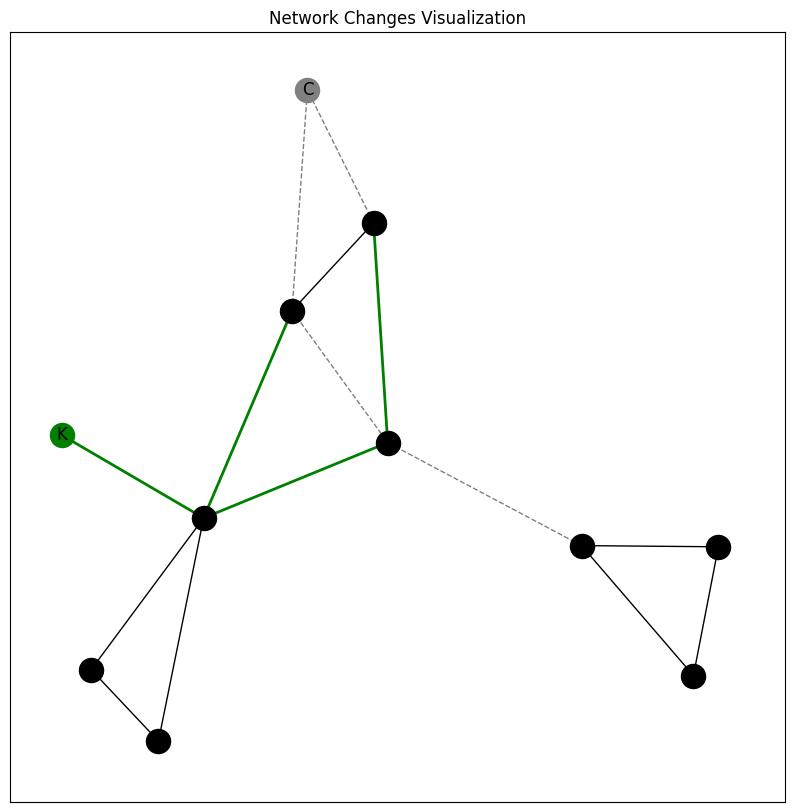

In [36]:
import networkx as nx
import matplotlib.pyplot as plt

# Create the first network
G1 = nx.Graph()
edges1 = [('A', 'B'), ('A', 'C'), ('B', 'C'), 
          ('D', 'E'), ('D', 'F'), ('E', 'F'), 
          ('G', 'H'), ('G', 'I'), ('H', 'I'),
          ('J', 'A'), ('J', 'G')]

G1.add_edges_from(edges1)

# Create the second network
G2 = nx.Graph()
edges2 = [('A', 'B'), ('A', 'D'), 
          ('D', 'E'), ('D', 'F'), ('E', 'F'),
          ('G', 'H'), ('G', 'I'), ('H', 'I'),
          ('J', 'B'), ('J', 'D'), ('K', 'D')]

G2.add_edges_from(edges2)

# Create a union of the two graphs for layout computation
G_union = nx.compose(G1, G2)

# Compute the layout only once
pos = nx.spring_layout(G_union)

# Find the common nodes and edges
common_nodes = set(G1.nodes()).intersection(set(G2.nodes()))
common_edges = set(G1.edges()).intersection(set(G2.edges()))

# Find the nodes and edges present in the first network but not in the second
dropped_nodes = set(G1.nodes()) - set(G2.nodes())
dropped_edges = set(G1.edges()) - set(G2.edges())

# Find the nodes and edges present in the second network but not in the first
new_nodes = set(G2.nodes()) - set(G1.nodes())
new_edges = set(G2.edges()) - set(G1.edges())

# Visualize the changes
plt.figure(figsize=(10, 10))

# Draw the parts of the network that remain the same in black
nx.draw_networkx_edges(G_union, pos, edgelist=common_edges)
nx.draw_networkx_nodes(G_union, pos, nodelist=common_nodes, node_color='black')

# Draw the parts of the network that have been dropped in grey and dashed
nx.draw_networkx_edges(G_union, pos, edgelist=dropped_edges, edge_color='grey', style='dashed')
nx.draw_networkx_nodes(G_union, pos, nodelist=dropped_nodes, node_color='grey')

# Draw the parts of the network that have been added in green and bold
nx.draw_networkx_edges(G_union, pos, edgelist=new_edges, edge_color='green', width=2.0)
nx.draw_networkx_nodes(G_union, pos, nodelist=new_nodes, node_color='green')

# Draw labels for the nodes
nx.draw_networkx_labels(G_union, pos)

plt.title("Network Changes Visualization")
plt.show()


/var/folders/x6/923dwt55237392mlk00827nh0000gn/T/ipykernel_36771/2003508981.py:62: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  while current_date <= end_date:
/var/folders/x6/923dwt55237392mlk00827nh0000gn/T/ipykernel_36771/2003508981.py:14: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  df_window = df[(df['date'] >= start_date) & (df['date'] <= end_date)]
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


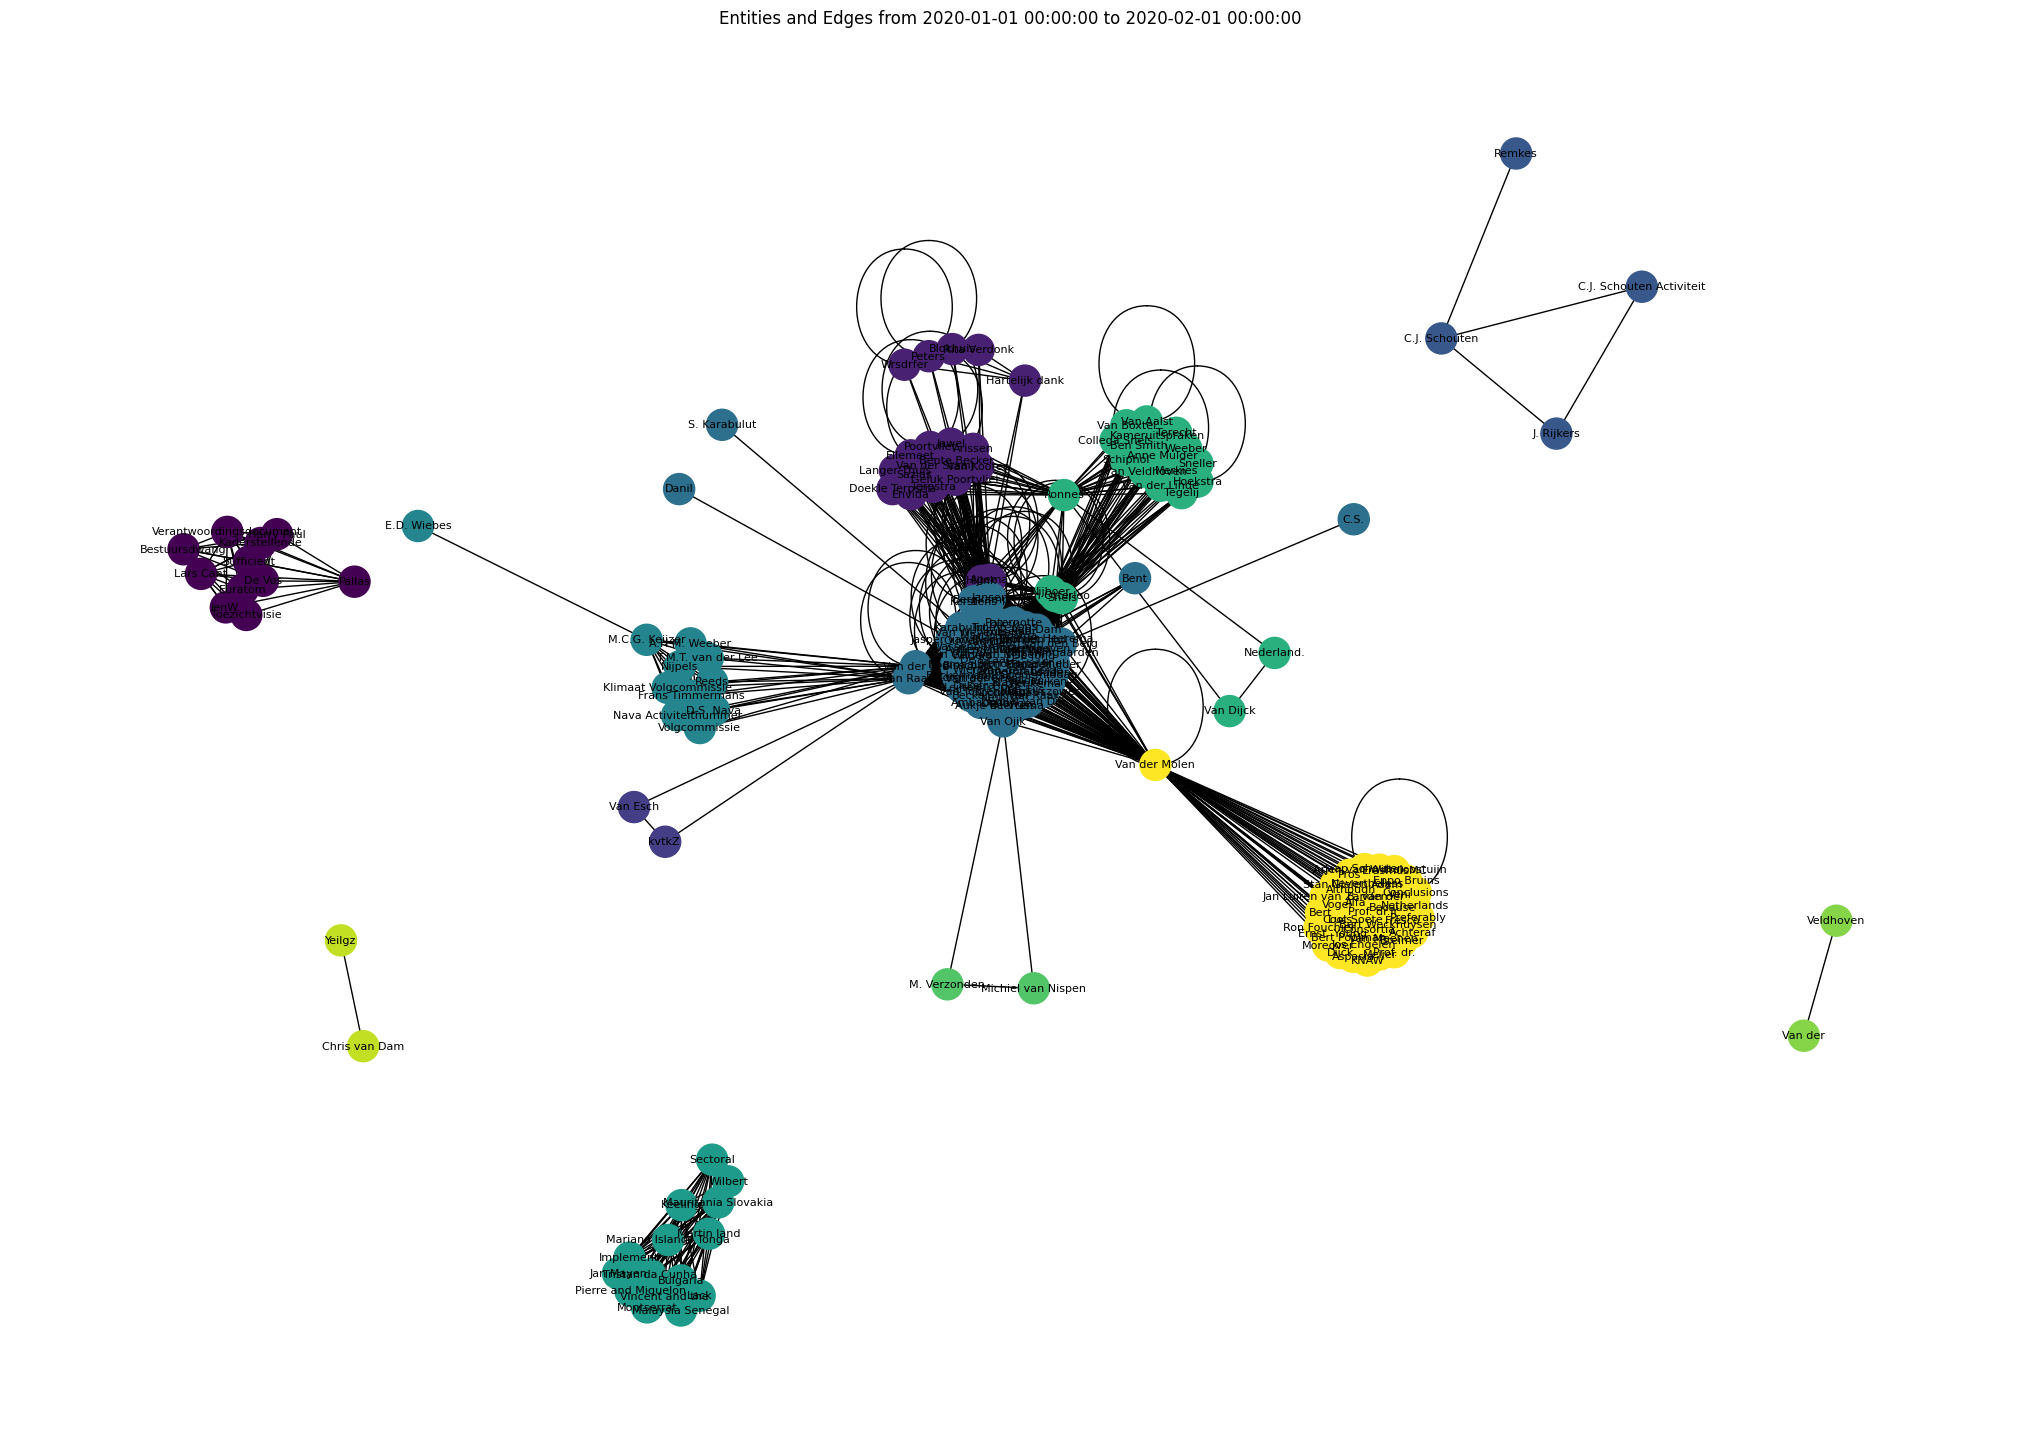

/var/folders/x6/923dwt55237392mlk00827nh0000gn/T/ipykernel_36771/2003508981.py:62: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  while current_date <= end_date:
/var/folders/x6/923dwt55237392mlk00827nh0000gn/T/ipykernel_36771/2003508981.py:14: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  df_window = df[(df['date'] >= start_date) & (df['date'] <= end_date)]
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


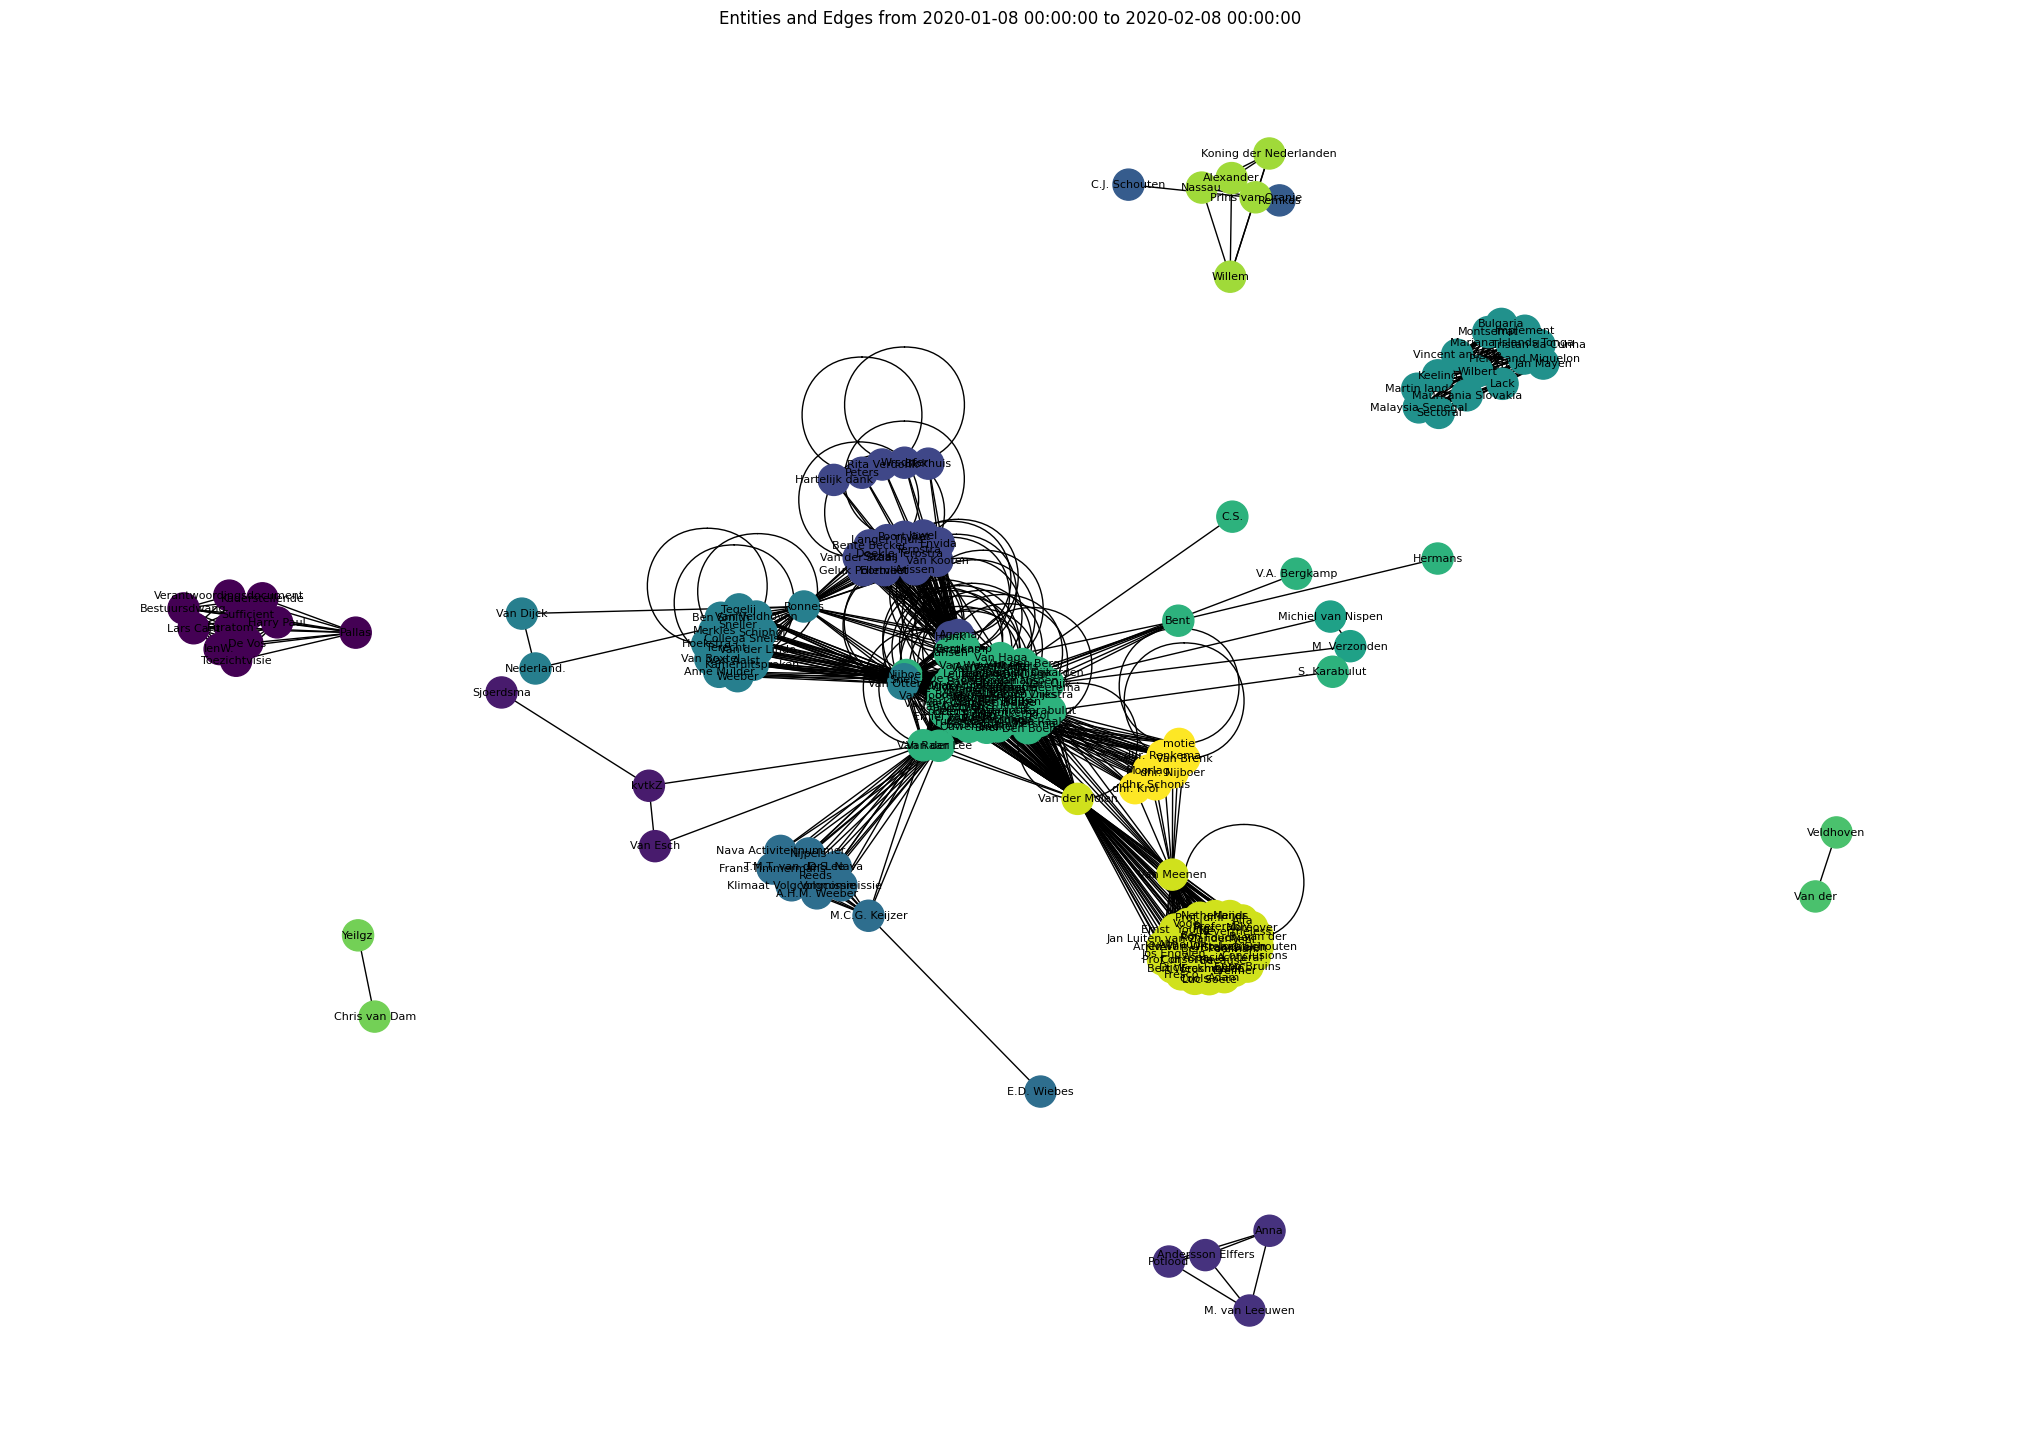

/var/folders/x6/923dwt55237392mlk00827nh0000gn/T/ipykernel_36771/2003508981.py:62: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  while current_date <= end_date:
/var/folders/x6/923dwt55237392mlk00827nh0000gn/T/ipykernel_36771/2003508981.py:14: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  df_window = df[(df['date'] >= start_date) & (df['date'] <= end_date)]
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


KeyboardInterrupt: 

In [37]:
### WITH FIXED SEED FOR BOTH NX AND LOUVAIN 
import ast
import datetime
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import community as community_louvain
import networkx as nx


# Define a function to create a graph from the given dataframe and time window
def create_graph(df, start_date, end_date):
   df_window = df[(df['date'] >= start_date) & (df['date'] <= end_date)]
   G = nx.Graph()
   for _, group in df_window.groupby('id'):
       entities = group['entity'].tolist()
       for i in range(len(entities)):
           for j in range(i + 1, len(entities)):
               G.add_edge(entities[i], entities[j])
   return G


# Define a function to draw the graph with increased distance between nodes within a cluster and color nodes based on Louvain community detection
def draw_graph(G, title):
   if G.order() == 0:  # Check if the graph is empty
     print(f"No entities to draw for {title}")
     return
   k = 4 / np.sqrt(G.order())
   k *= 1.5
   pos = nx.spring_layout(G, k=k, iterations=100, seed=1)
   plt.figure(figsize=(10*2, 7*2))
  
   # Louvain community detection
   partition = community_louvain.best_partition(G, random_state=1)
  
   # Color nodes based on their community
   cmap = plt.cm.get_cmap('viridis', max(partition.values()) + 1)
   nx.draw(G, pos, node_color=[cmap(partition[node]) for node in G.nodes()],
           with_labels=True, node_size=500, font_size=8, cmap=cmap)
  
   plt.title(title)
   plt.show();


# Set up the time window parameters
#window_size = datetime.timedelta(days=30)  # 30-day sliding window
#step_size = datetime.timedelta(days=7)  # Move the window every 7 

# Make the window and step sizes time periods relative.
window_size = relativedelta(months=1)  # 30-day sliding window
step_size = relativedelta(weeks=1)  # Move the window every 7 days


#start_date = df['date'].min()
start_date = pd.to_datetime('2020-01-01')
end_date = df['date'].max() - window_size


# Iterate through the time range and create graphs for each window
current_date = start_date
while current_date <= end_date:
   G = create_graph(df, current_date, current_date + window_size)
   draw_graph(G, f"Entities and Edges from {current_date} to {current_date + window_size}")
   current_date += step_size


## Tests with color nodes 

/var/folders/x6/923dwt55237392mlk00827nh0000gn/T/ipykernel_36771/2039090600.py:13: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  df_window = df[(df['date'] >= start_date) & (df['date'] <= end_date)]
/var/folders/x6/923dwt55237392mlk00827nh0000gn/T/ipykernel_36771/2039090600.py:13: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  df_window = df[(df['date'] >= start_date) & (df['date'] <= end_date)]
/var/folders/x6/923dwt55237392mlk00827nh0000gn/T/ipykernel_36771/2039090600.py:13: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavi

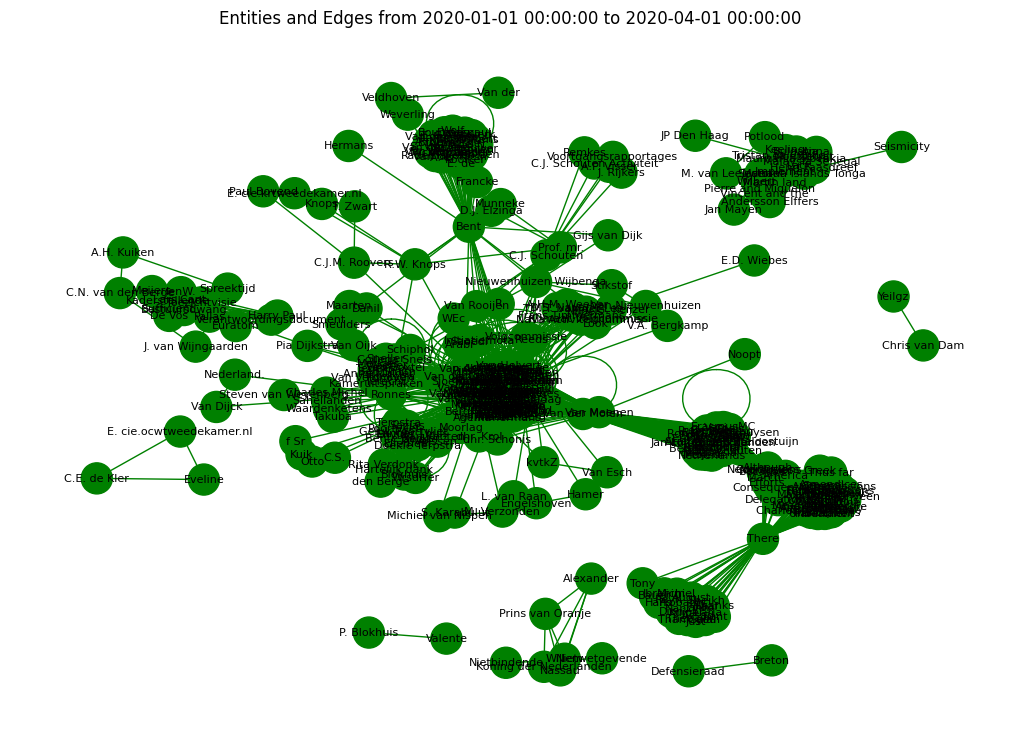

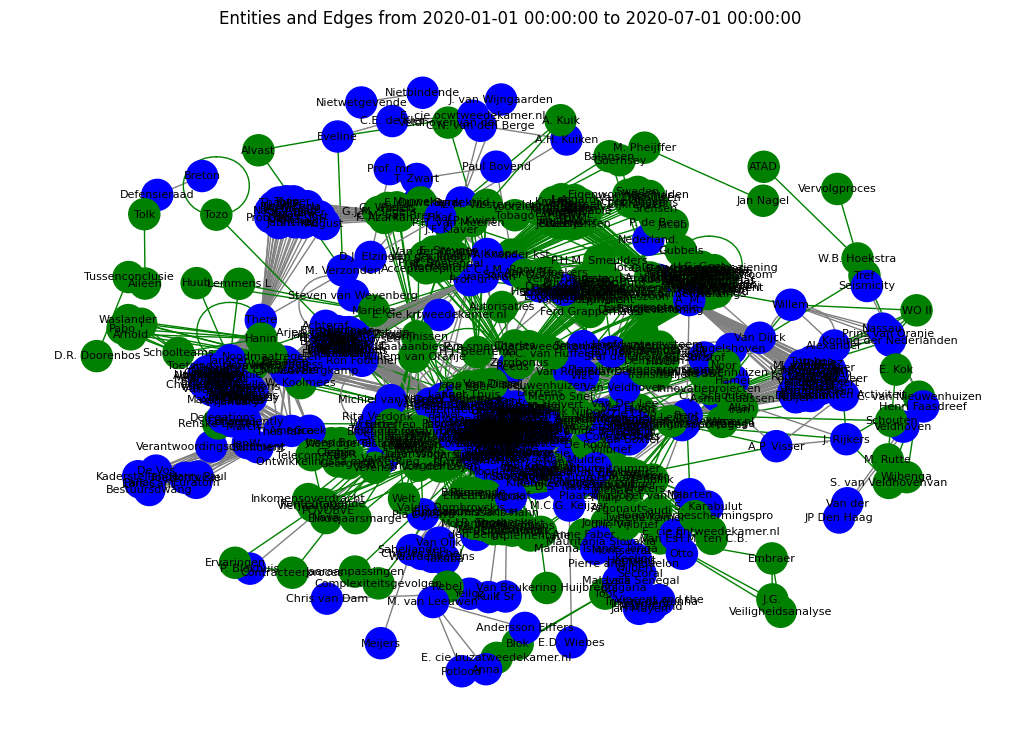

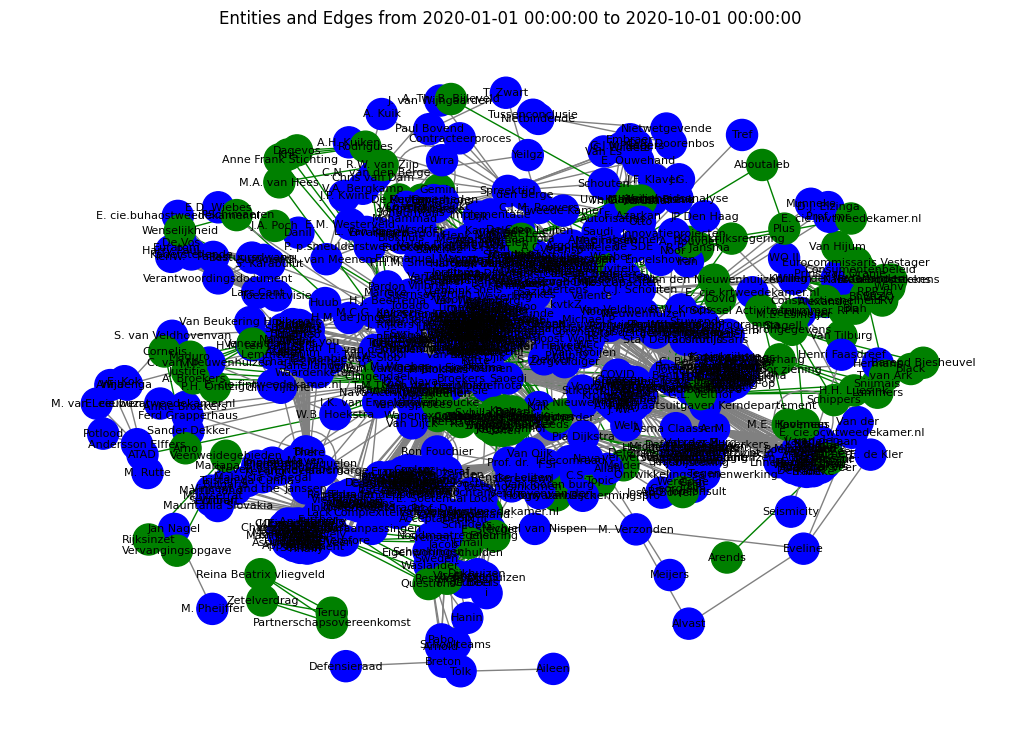

In [51]:
import ast
import datetime
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import community as community_louvain
from dateutil.relativedelta import relativedelta


# Define a function to create a graph from the given dataframe and time window
def create_graph(df, start_date, end_date):
    df_window = df[(df['date'] >= start_date) & (df['date'] <= end_date)]
    G = nx.Graph()
    for _, group in df_window.groupby('id'):
        entities = group['entity'].tolist()
        for i in range(len(entities)):
            for j in range(i + 1, len(entities)):
                G.add_edge(entities[i], entities[j])
    return G


# Define a function to draw the graph with changes highlighted and increased spacing between nodes
def draw_graph_changes(G, prev_G, title):
    if G.order() == 0:  # Check if the graph is empty
        print(f"No entities to draw for {title}")
        return

    added_nodes = set(G.nodes()) - set(prev_G.nodes())
    dropped_nodes = set(prev_G.nodes()) - set(G.nodes())
    added_edges = set(G.edges()) - set(prev_G.edges())
    dropped_edges = set(prev_G.edges()) - set(G.edges())

    node_colors = ['green' if node in added_nodes else 'red' if node in dropped_nodes else 'blue' for node in G.nodes()]
    edge_colors = ['green' if edge in added_edges else 'red' if edge in dropped_edges else 'gray' for edge in G.edges()]

    plt.figure(figsize=(10, 7))
    pos = nx.spring_layout(G, seed=1, k=0.2)  # Increase the spacing between nodes with 'k' parameter
    nx.draw(G, pos, node_color=node_colors, edge_color=edge_colors, with_labels=True, node_size=500, font_size=8)
    plt.title(title)
    plt.show()


# Set up the time window parameters
window_size = relativedelta(months=3)  # 30-day sliding window
step_size = relativedelta(weeks=1)  # Move the window every 7 days

# Set the first three time windows
start_date = pd.to_datetime('2020-01-01')
end_date_1 = start_date + window_size
end_date_2 = end_date_1 + window_size
end_date_3 = end_date_2 + window_size

# Create the graphs for the first three time windows
G1 = create_graph(df, start_date, end_date_1)
G2 = create_graph(df, start_date, end_date_2)
G3 = create_graph(df, start_date, end_date_3)

# Draw the graphs with changes highlighted and increased spacing between nodes
draw_graph_changes(G1, nx.Graph(), f"Entities and Edges from {start_date} to {end_date_1}")
draw_graph_changes(G2, G1, f"Entities and Edges from {start_date} to {end_date_2}")
draw_graph_changes(G3, G2, f"Entities and Edges from {start_date} to {end_date_3}")


/var/folders/x6/923dwt55237392mlk00827nh0000gn/T/ipykernel_36771/2085723590.py:13: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  df_window = df[(df['date'] >= start_date) & (df['date'] <= end_date)]
/var/folders/x6/923dwt55237392mlk00827nh0000gn/T/ipykernel_36771/2085723590.py:13: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  df_window = df[(df['date'] >= start_date) & (df['date'] <= end_date)]
/var/folders/x6/923dwt55237392mlk00827nh0000gn/T/ipykernel_36771/2085723590.py:13: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavi

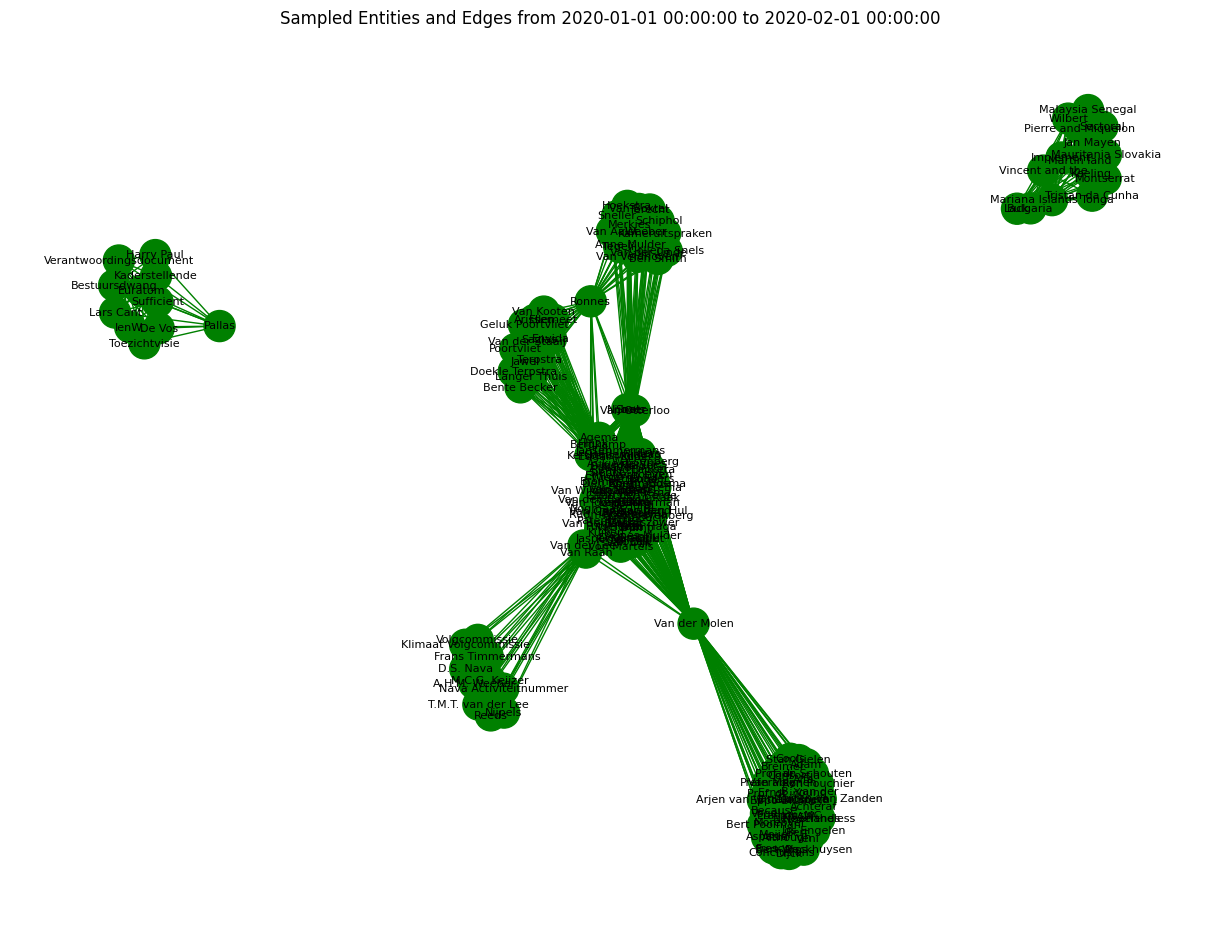

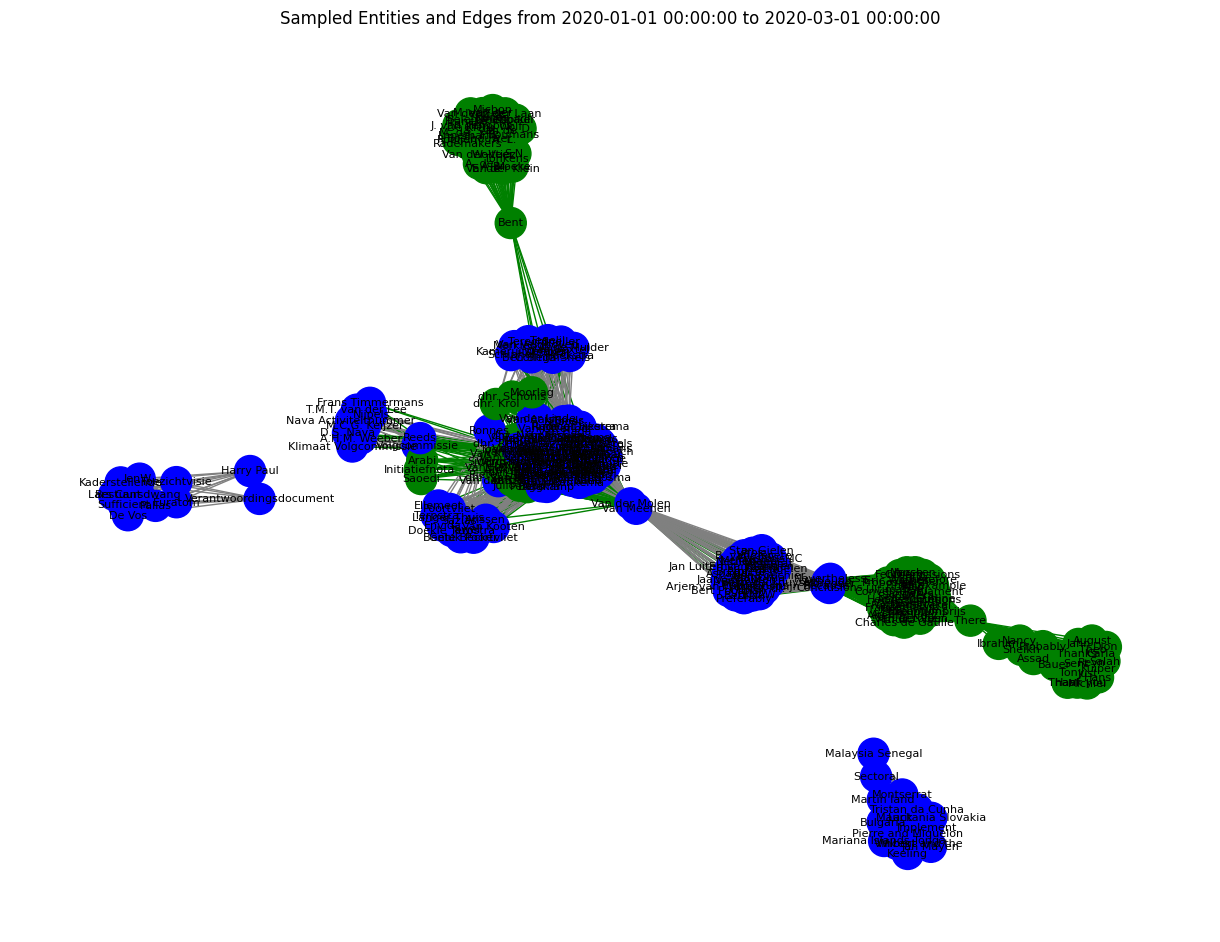

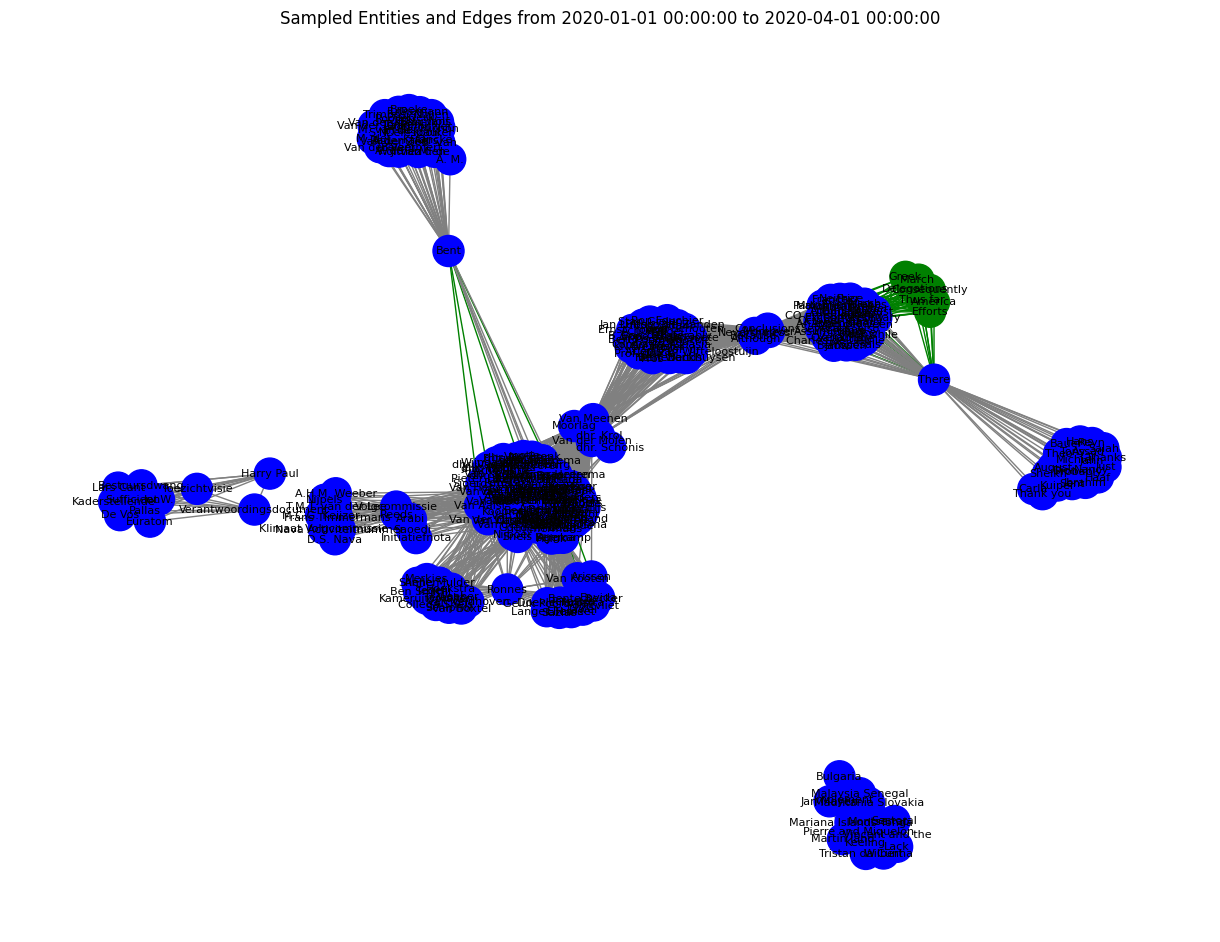

In [41]:
import ast
import datetime
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import community as community_louvain
from dateutil.relativedelta import relativedelta


# Define a function to create a graph from the given dataframe and time window
def create_graph(df, start_date, end_date):
    df_window = df[(df['date'] >= start_date) & (df['date'] <= end_date)]
    G = nx.Graph()
    for _, group in df_window.groupby('id'):
        entities = group['entity'].tolist()
        for i in range(len(entities)):
            for j in range(i + 1, len(entities)):
                G.add_edge(entities[i], entities[j])
    return G


# Define a function to remove self-loops from the graph
def remove_self_loops(G):
    G.remove_edges_from(nx.selfloop_edges(G))


# Define a function to perform k-core sampling on the graph
def k_core_sampling(G, k):
    G_sampled = nx.k_core(G, k=k)
    return G_sampled


# Define a function to draw the graph with changes highlighted and increased spacing between nodes
def draw_graph_changes(G, prev_G, title):
    if G.order() == 0:  # Check if the graph is empty
        print(f"No entities to draw for {title}")
        return

    added_nodes = set(G.nodes()) - set(prev_G.nodes())
    dropped_nodes = set(prev_G.nodes()) - set(G.nodes())
    added_edges = set(G.edges()) - set(prev_G.edges())
    dropped_edges = set(prev_G.edges()) - set(G.edges())

    node_colors = ['green' if node in added_nodes else 'red' if node in dropped_nodes else 'blue' for node in G.nodes()]
    edge_colors = ['green' if edge in added_edges else 'red' if edge in dropped_edges else 'gray' for edge in G.edges()]

    plt.figure(figsize=(12, 9))  # Adjust the figure size as per your preference
    pos = nx.spring_layout(G, seed=1, k=0.2)  # Increase the spacing between nodes with 'k' parameter
    nx.draw(G, pos, node_color=node_colors, edge_color=edge_colors, with_labels=True, node_size=500, font_size=8)
    plt.title(title)
    plt.show()


# Set up the time window parameters
window_size = relativedelta(months=1)  # 30-day sliding window
step_size = relativedelta(weeks=1)  # Move the window every 7 days

# Set the first three time windows
start_date = pd.to_datetime('2020-01-01')
end_date_1 = start_date + window_size
end_date_2 = end_date_1 + window_size
end_date_3 = end_date_2 + window_size

# Create the graphs for the first three time windows
G1 = create_graph(df, start_date, end_date_1)
G2 = create_graph(df, start_date, end_date_2)
G3 = create_graph(df, start_date, end_date_3)

# Remove self-loops from the graphs
remove_self_loops(G1)
remove_self_loops(G2)
remove_self_loops(G3)

# Perform k-core sampling on the graphs
k = 10  # Adjust the value of k to control the number of nodes
G1_sampled = k_core_sampling(G1, k)
G2_sampled = k_core_sampling(G2, k)
G3_sampled = k_core_sampling(G3, k)

# Draw the sampled graphs with changes highlighted and increased spacing between nodes
draw_graph_changes(G1_sampled, nx.Graph(), f"Sampled Entities and Edges from {start_date} to {end_date_1}")
draw_graph_changes(G2_sampled, G1_sampled, f"Sampled Entities and Edges from {start_date} to {end_date_2}")
draw_graph_changes(G3_sampled, G2_sampled, f"Sampled Entities and Edges from {start_date} to {end_date_3}")


/var/folders/x6/923dwt55237392mlk00827nh0000gn/T/ipykernel_36771/2073681701.py:13: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  df_window = df[(df['date'] >= start_date) & (df['date'] <= end_date)]
/var/folders/x6/923dwt55237392mlk00827nh0000gn/T/ipykernel_36771/2073681701.py:13: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  df_window = df[(df['date'] >= start_date) & (df['date'] <= end_date)]
/var/folders/x6/923dwt55237392mlk00827nh0000gn/T/ipykernel_36771/2073681701.py:13: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavi

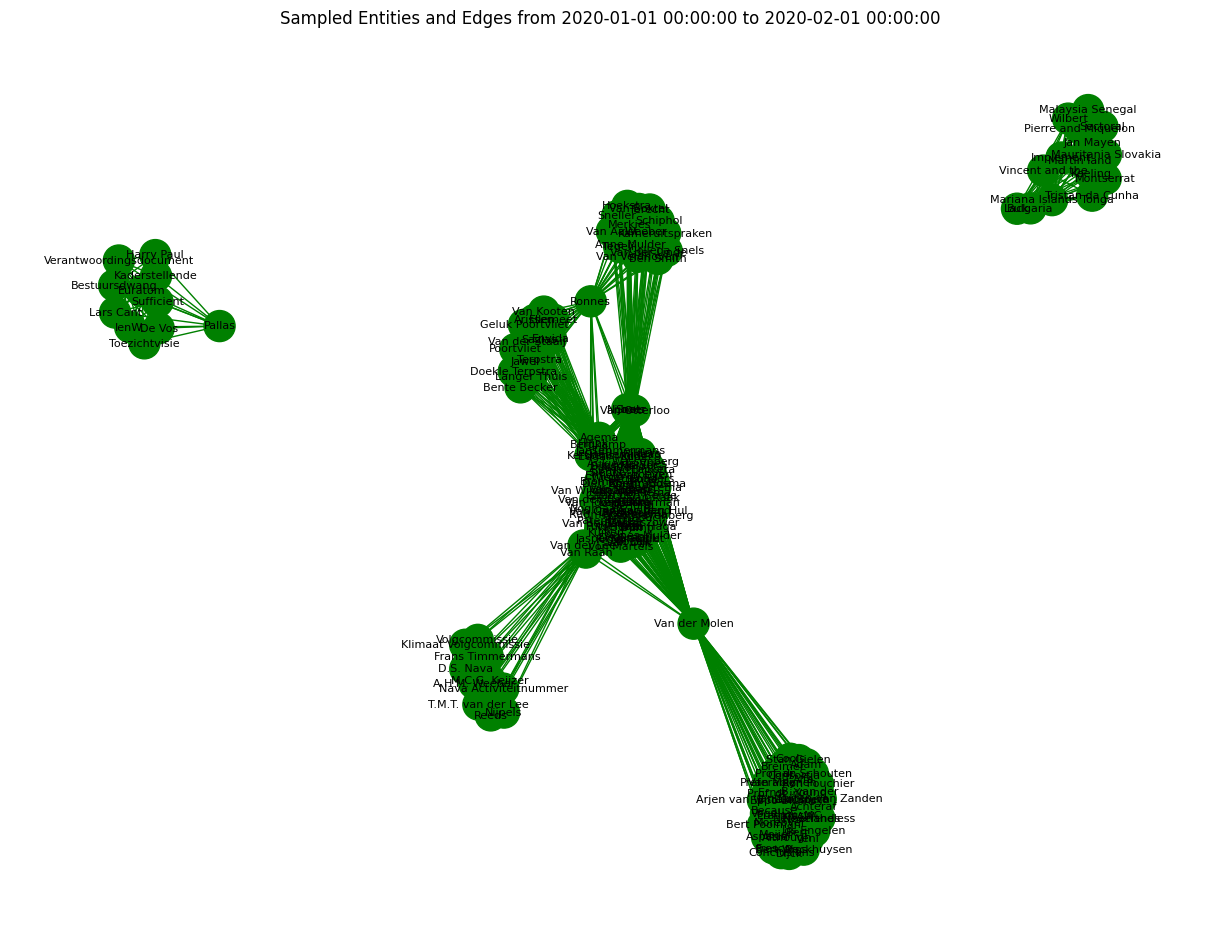

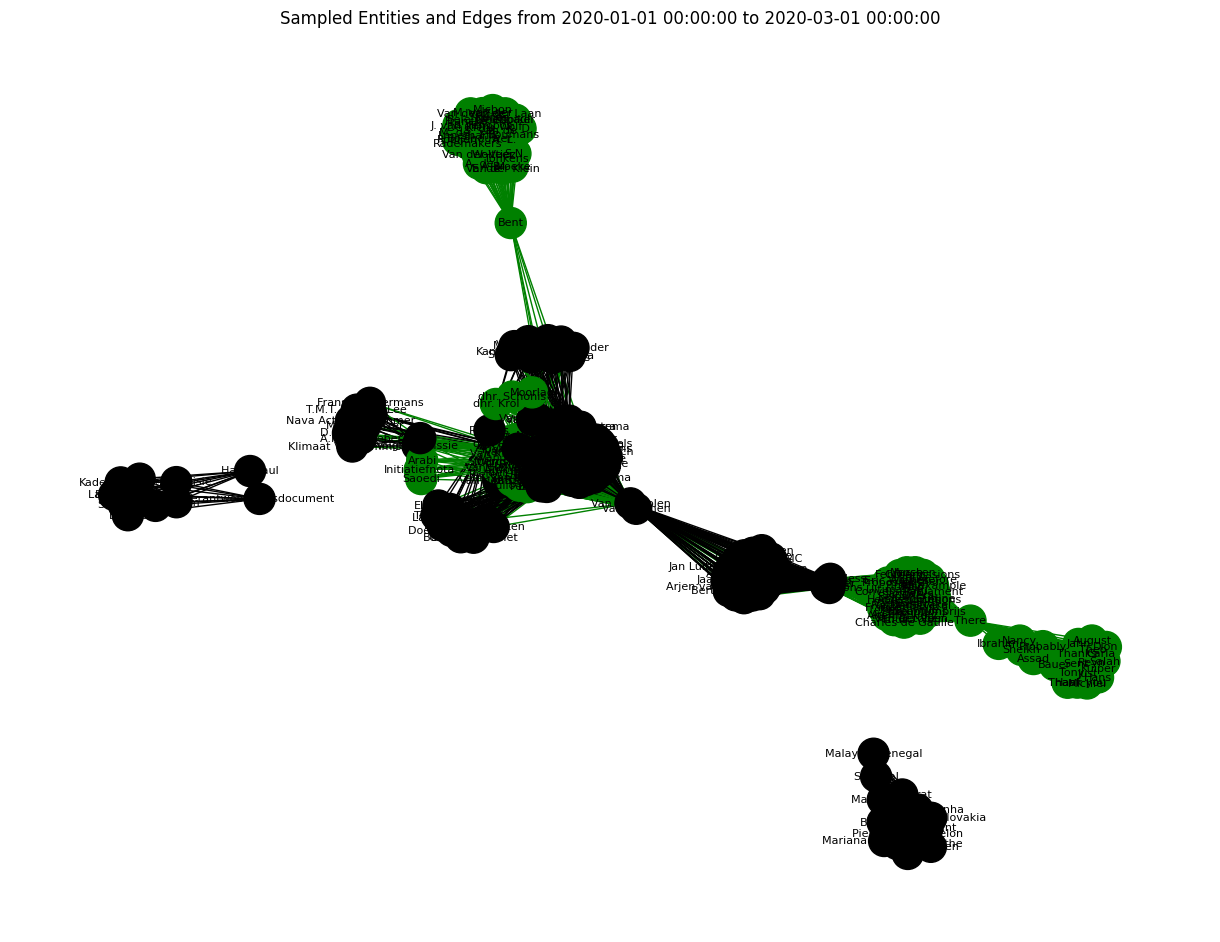

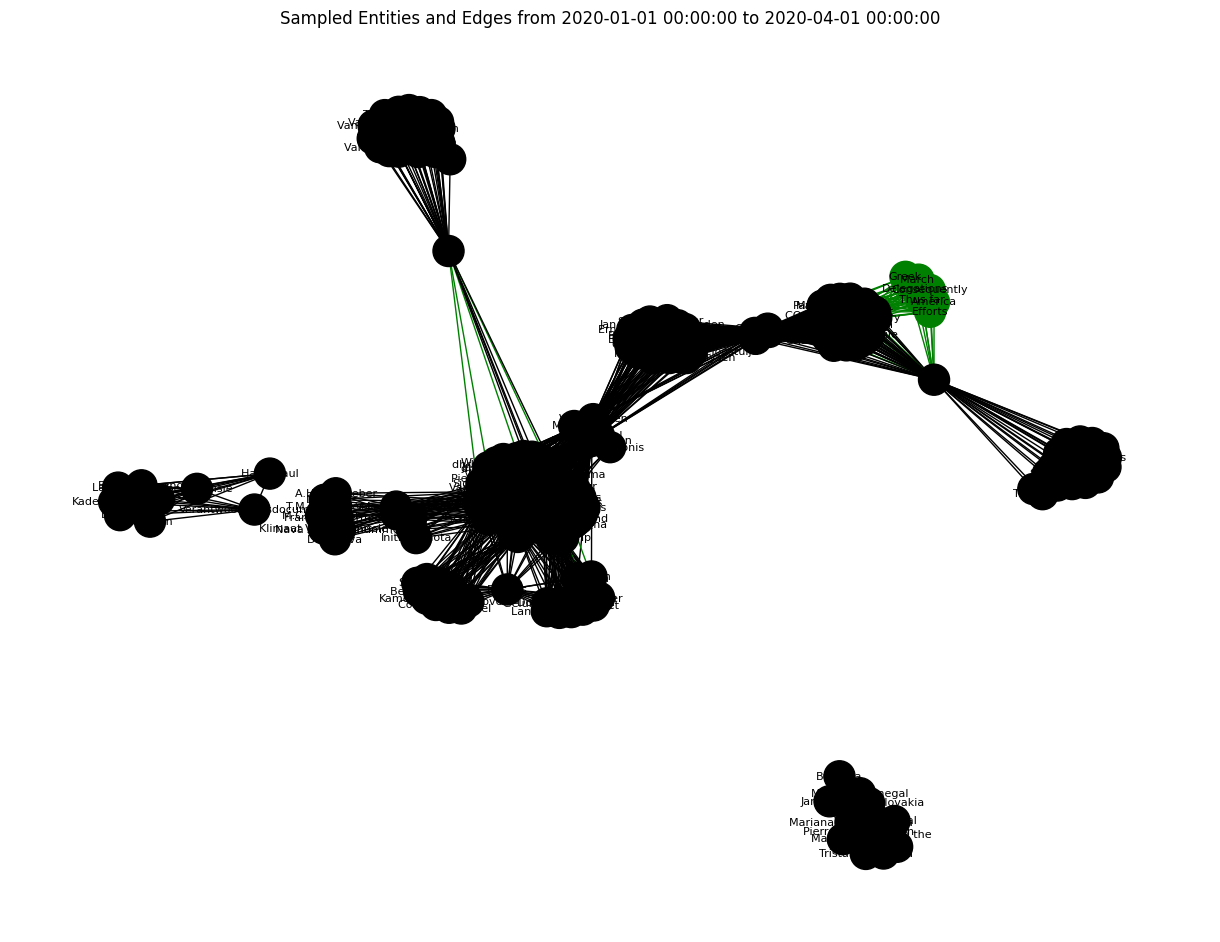

In [46]:
import ast
import datetime
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import community as community_louvain
from dateutil.relativedelta import relativedelta


# Define a function to create a graph from the given dataframe and time window
def create_graph(df, start_date, end_date):
    df_window = df[(df['date'] >= start_date) & (df['date'] <= end_date)]
    G = nx.Graph()
    for _, group in df_window.groupby('id'):
        entities = group['entity'].tolist()
        for i in range(len(entities)):
            for j in range(i + 1, len(entities)):
                G.add_edge(entities[i], entities[j])
    return G


# Define a function to remove self-loops from the graph
def remove_self_loops(G):
    G.remove_edges_from(nx.selfloop_edges(G))


# Define a function to perform k-core sampling on the graph
def k_core_sampling(G, k):
    G_sampled = nx.k_core(G, k=k)
    return G_sampled


# Define a function to draw the graph with changes highlighted and increased spacing between nodes
def draw_graph_changes(G, prev_G, title):
    if G.order() == 0:  # Check if the graph is empty
        print(f"No entities to draw for {title}")
        return

    added_nodes = set(G.nodes()) - set(prev_G.nodes())
    dropped_nodes = set(prev_G.nodes()) - set(G.nodes())
    added_edges = set(G.edges()) - set(prev_G.edges())
    dropped_edges = set(prev_G.edges()) - set(G.edges())

    node_colors = {node: 'black' for node in G.nodes()}  # Set initial node color as black
    edge_colors = {edge: 'black' for edge in G.edges()}  # Set initial edge color as black

    # Update colors for added and dropped nodes and edges
    for node in added_nodes:
        node_colors[node] = 'green'
    for node in dropped_nodes:
        node_colors[node] = 'red'
    for edge in added_edges:
        edge_colors[edge] = 'green'
    for edge in dropped_edges:
        edge_colors[edge] = 'red'

    plt.figure(figsize=(12, 9))  # Adjust the figure size as per your preference
    pos = nx.spring_layout(G, seed=1, k=0.2)  # Increase the spacing between nodes with 'k' parameter
    nx.draw(G, pos, node_color=list(node_colors.values()), edge_color=list(edge_colors.values()), with_labels=True,
            node_size=500, font_size=8)
    plt.title(title)
    plt.show()


# Set up the time window parameters
window_size = relativedelta(months=1)  # 30-day sliding window
step_size = relativedelta(weeks=1)  # Move the window every 7 days

# Set the first three time windows
start_date = pd.to_datetime('2020-01-01')
end_date_1 = start_date + window_size
end_date_2 = end_date_1 + window_size
end_date_3 = end_date_2 + window_size

# Create the graphs for the first three time windows
G1 = create_graph(df, start_date, end_date_1)
G2 = create_graph(df, start_date, end_date_2)
G3 = create_graph(df, start_date, end_date_3)

# Remove self-loops from the graphs
remove_self_loops(G1)
remove_self_loops(G2)
remove_self_loops(G3)

# Perform k-core sampling on the graphs
k = 10  # Adjust the value of k to control the number of nodes
G1_sampled = k_core_sampling(G1, k)
G2_sampled = k_core_sampling(G2, k)
G3_sampled = k_core_sampling(G3, k)

# Draw the sampled graphs with changes highlighted and increased spacing between nodes
draw_graph_changes(G1_sampled, nx.Graph(), f"Sampled Entities and Edges from {start_date} to {end_date_1}")
draw_graph_changes(G2_sampled, G1_sampled, f"Sampled Entities and Edges from {start_date} to {end_date_2}")
draw_graph_changes(G3_sampled, G2_sampled, f"Sampled Entities and Edges from {start_date} to {end_date_3}")


/var/folders/x6/923dwt55237392mlk00827nh0000gn/T/ipykernel_36771/2859291097.py:13: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  df_window = df[(df['date'] >= start_date) & (df['date'] <= end_date)]
/var/folders/x6/923dwt55237392mlk00827nh0000gn/T/ipykernel_36771/2859291097.py:13: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  df_window = df[(df['date'] >= start_date) & (df['date'] <= end_date)]
/var/folders/x6/923dwt55237392mlk00827nh0000gn/T/ipykernel_36771/2859291097.py:13: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavi

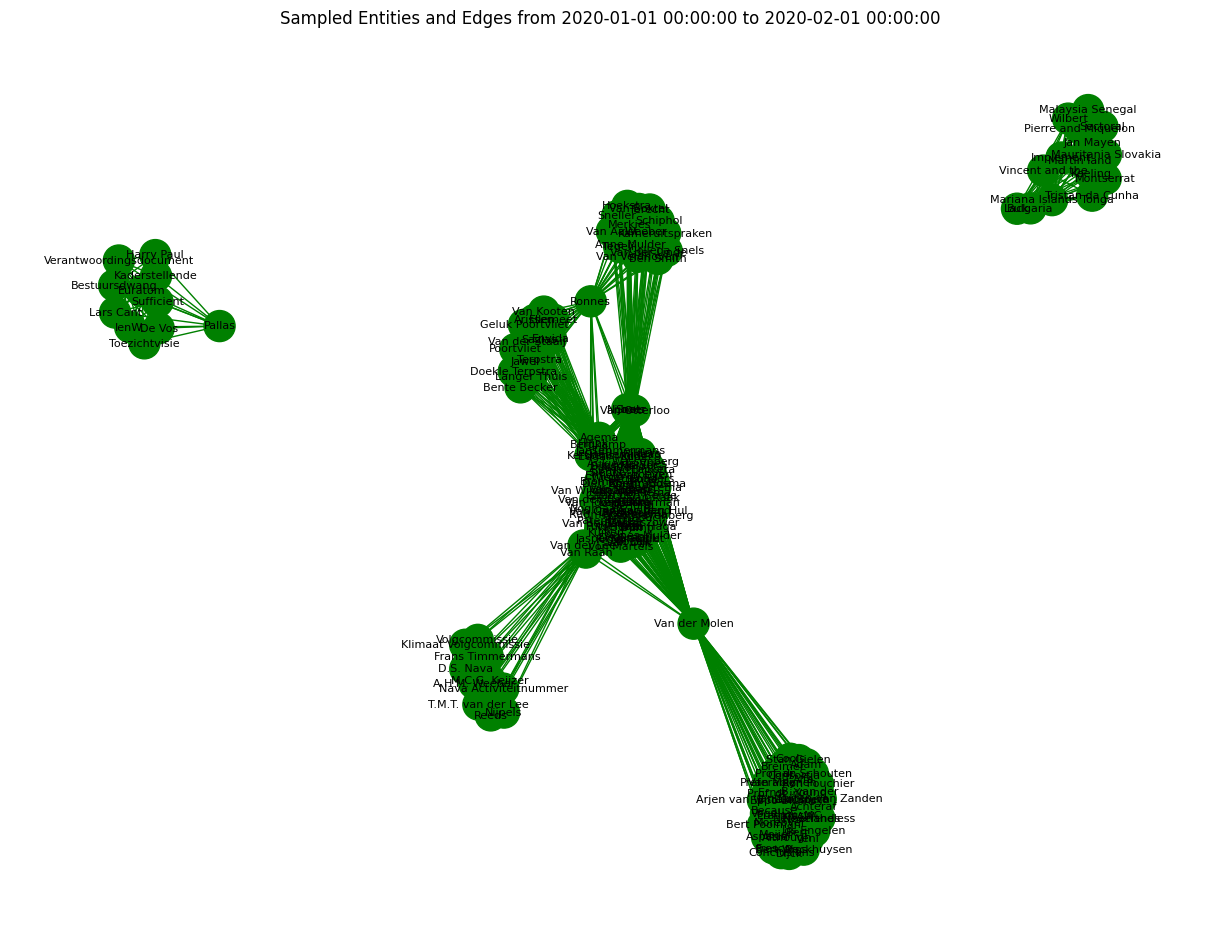

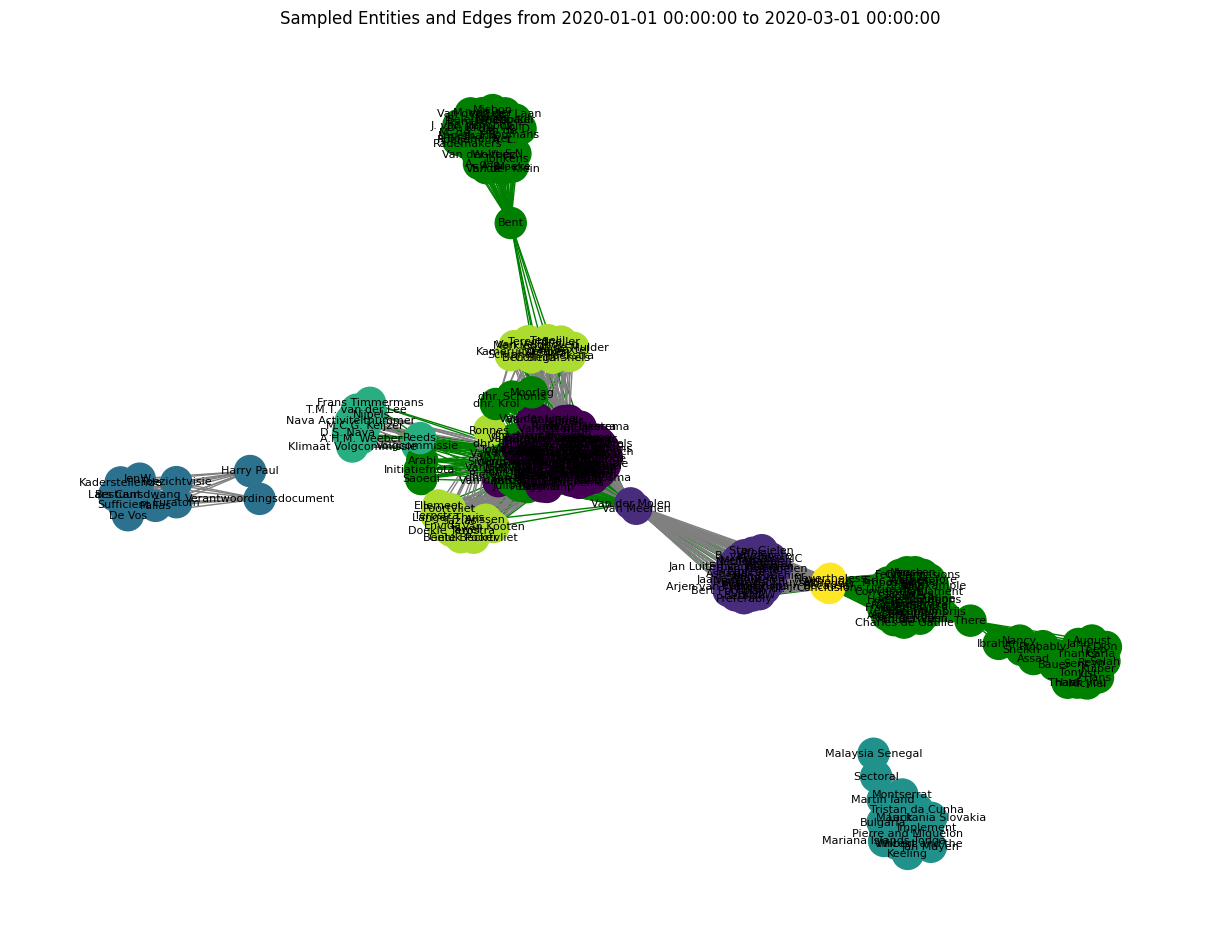

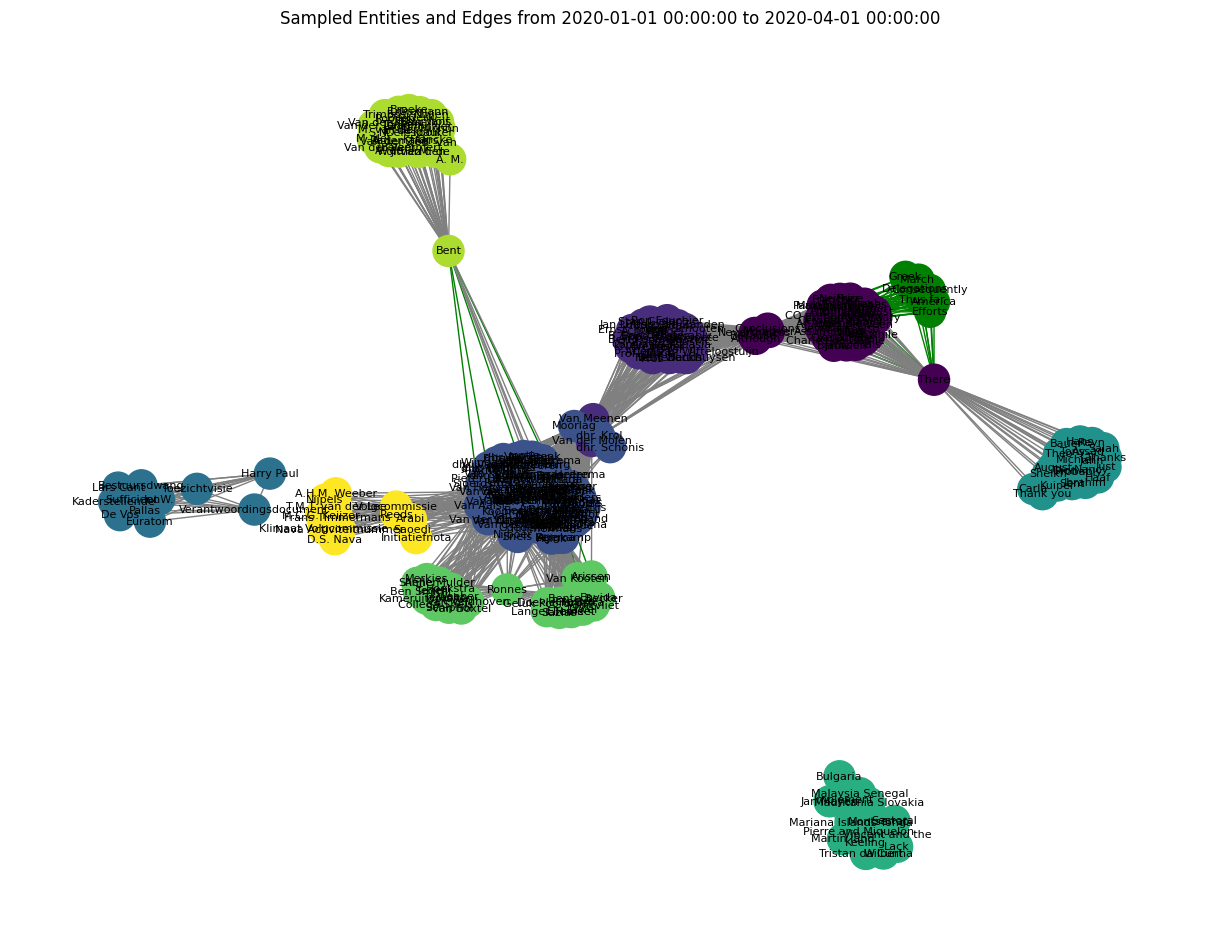

In [49]:
import ast
import datetime
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import community as community_louvain
from dateutil.relativedelta import relativedelta


# Define a function to create a graph from the given dataframe and time window
def create_graph(df, start_date, end_date):
    df_window = df[(df['date'] >= start_date) & (df['date'] <= end_date)]
    G = nx.Graph()
    for _, group in df_window.groupby('id'):
        entities = group['entity'].tolist()
        for i in range(len(entities)):
            for j in range(i + 1, len(entities)):
                G.add_edge(entities[i], entities[j])
    return G


# Define a function to remove self-loops from the graph
def remove_self_loops(G):
    G.remove_edges_from(nx.selfloop_edges(G))


# Define a function to perform k-core sampling on the graph
def k_core_sampling(G, k):
    G_sampled = nx.k_core(G, k=k)
    return G_sampled


# Define a function to draw the graph with changes highlighted and increased spacing between nodes
def draw_graph_changes(G, prev_G, title):
    if G.order() == 0:  # Check if the graph is empty
        print(f"No entities to draw for {title}")
        return

    added_nodes = set(G.nodes()) - set(prev_G.nodes())
    dropped_nodes = set(prev_G.nodes()) - set(G.nodes())
    added_edges = set(G.edges()) - set(prev_G.edges())
    dropped_edges = set(prev_G.edges()) - set(G.edges())

    # Louvain community detection
    partition = community_louvain.best_partition(G)

    cmap = plt.cm.get_cmap('viridis', max(partition.values()) + 1)
    node_colors = {node: cmap(partition[node]) for node in G.nodes()}
    edge_colors = {edge: 'gray' for edge in G.edges()}

    # Update colors for added and dropped nodes and edges
    for node in added_nodes:
        node_colors[node] = 'green'
    for node in dropped_nodes:
        node_colors[node] = 'red'
    for edge in added_edges:
        edge_colors[edge] = 'green'
    for edge in dropped_edges:
        edge_colors[edge] = 'red'

    plt.figure(figsize=(12, 9))  # Adjust the figure size as per your preference
    pos = nx.spring_layout(G, seed=1, k=0.2)  # Increase the spacing between nodes with 'k' parameter
    nx.draw(G, pos, node_color=list(node_colors.values()), edge_color=list(edge_colors.values()), with_labels=True,
            node_size=500, font_size=8, cmap=cmap, edge_cmap='gray')
    plt.title(title)
    plt.show()


# Set up the time window parameters
window_size = relativedelta(months=1)  # 30-day sliding window
step_size = relativedelta(weeks=1)  # Move the window every 7 days

# Set the first three time windows
start_date = pd.to_datetime('2020-01-01')
end_date_1 = start_date + window_size
end_date_2 = end_date_1 + window_size
end_date_3 = end_date_2 + window_size

# Create the graphs for the first three time windows
G1 = create_graph(df, start_date, end_date_1)
G2 = create_graph(df, start_date, end_date_2)
G3 = create_graph(df, start_date, end_date_3)

# Remove self-loops from the graphs
remove_self_loops(G1)
remove_self_loops(G2)
remove_self_loops(G3)

# Perform k-core sampling on the graphs
k = 10  # Adjust the value of k to control the number of nodes
G1_sampled = k_core_sampling(G1, k)
G2_sampled = k_core_sampling(G2, k)
G3_sampled = k_core_sampling(G3, k)

# Draw the sampled graphs with changes highlighted and increased spacing between nodes
draw_graph_changes(G1_sampled, nx.Graph(), f"Sampled Entities and Edges from {start_date} to {end_date_1}")
draw_graph_changes(G2_sampled, G1_sampled, f"Sampled Entities and Edges from {start_date} to {end_date_2}")
draw_graph_changes(G3_sampled, G2_sampled, f"Sampled Entities and Edges from {start_date} to {end_date_3}")
